In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from operator import itemgetter
import random
import sys
import time
from IPython.display import clear_output

In [2]:
ratings = pd.read_csv("dataset/MovieLens100K",sep=" ",names=["user_id","item_id","rating","timestamp"])
print(ratings.head(10))
print(ratings.shape)

   user_id  item_id  rating  timestamp
0      259      255       4  874724710
1      259      286       4  874724727
2      259      298       4  874724754
3      259      185       4  874724781
4      259      173       4  874724843
5      259      772       4  874724882
6      259      108       4  874724882
7      259      288       3  874724905
8      259      928       4  874724937
9      259      117       4  874724988
(100000, 4)


In [3]:
USERS,ITEMS = ratings.nunique()[:2]

RATINGS = ratings.shape[0]
profiles = [ [] for i in range(USERS) ]
profiles_train = [ [] for i in range(USERS) ]
profiles_test = [ {} for i in range(USERS) ]
V = [ {} for i in range(USERS) ]

support = [0]*ITEMS
for index,row in ratings.iterrows():
  profiles[row['user_id']-1].append(row['item_id']-1)
  
for profile in profiles:
  for item in profile:
    support[item] += 1

In [4]:
precedenceCount = [ [0]*ITEMS for i in range(ITEMS) ]
for profile in profiles:
  for i in range(len(profile)):
    for j in range(i+1,len(profile)):
      precedenceCount[profile[i]][profile[j]] += 1

In [5]:
def scoreP(profile,item):
  pp = []
  top_l = 2
  for l in profile:
    pp.append(precedenceCount[l][item]/support[l])
  pp.sort(reverse=True)
  sc = support[item]/USERS
  for p in pp[:top_l]:
    sc *= p
  return sc

def scoreR(profile,item):
  pp = []
  top_l = 2
  for l in profile:
    pp.append(profile[l]*precedenceCount[l][item]/support[l])
  pp.sort(reverse=True)
  sc = support[item]/USERS
  for p in pp[:top_l]:
    sc *= p
  return sc

In [6]:
def evaluate( group,recommendations,top_K,group_items ):
  prec_k = [0]*top_K
  rec_k = [0]*top_K
  for user in group:
    k = 0
    rec_used = 0
    used  = 0
    for item in profiles_test[user]:
      if item not in group_items:
        used += 1
    if used== 0:
      continue
    for item in recommendations:
      if item in profiles_test[user]:
        rec_used += 1
      prec_k[k] += rec_used/(k+1)
      rec_k[k] += rec_used/used
      k+=1
  return prec_k,rec_k

In [7]:
def conformal( profile_wt , profile ,precedenceCount , rec_candidates , Epsilon , top_K , group , G):
  n = len(profile)
  recommendations = {}
  
  Vg = set()
  for user in group:
    for v in V[user]:
      Vg.add(v)
  
  avg_r = sum(rec_candidates.values())/len(rec_candidates)
  avg_p = sum(profile_wt.values())/n
  scale = avg_p/avg_r
  
  for r in rec_candidates:
    avg_p = 0
    p_vec = []
    for v in Vg:
      p = 0
      pp_nv =  rec_candidates[r]* scale * precedenceCount[r][v]/support[r]
      for item in profile:
        if profile_wt[item]*precedenceCount[item][v]/support[item] <= pp_nv:
          p += 1
      p /= max(1,len(profile) )
      avg_p += p
    recommendations[r] = avg_p
  recommendations  = dict(sorted(recommendations.items(),key=itemgetter(1),reverse=True)[:top_K])

  return recommendations

In [8]:
def main( G,top_K,Rounds ):
  avg_prec_k = [0]*top_K
  avg_rec_k = [0]*top_K
  avg_cprec_k = [0]*top_K
  avg_crec_k = [0]*top_K
  
  
  for run in range(Rounds):
    
    prec_k = [0]*top_K
    rec_k = [0]*top_K
    cprec_k = [0]*top_K
    crec_k = [0]*top_K
      
    for user in range(USERS):
      n = len(profiles[user])
      profiles_train[user] = profiles[user][:n*45//100]
      temp = profiles[user][n*45//100:]
      random.shuffle(temp)
      V[user] = temp[:n*15//100]
      profiles_test[user] = set(temp[n*15//100:])
    
    r = [ i for i in range(USERS) ]
    random.shuffle(r)
    groups = [ [ r[G*i+j] for j in range(G) ] for i in range(USERS//G) ] 
    G_count = USERS//G
    ins = 0
    
    for group in groups:
      for user in group:
        for item1 in profiles_test[user]:
          support[item1] -= 1
          for item2 in profiles_train[user]:
            precedenceCount[item2][item1] -= 1  
      
      group_items = set({})
      for user in group:
        for item in profiles_train[user]:
          group_items.add(item)
      
      Vg = {} #virtual profile
      Vl = []
      for item in group_items:
        item_score = 0
        for user in group:
          if item in profiles_train[user]:
            item_score += 1
          else:
            item_score += scoreP(profiles_train[user],item)
        Vg[item] = item_score/G
        Vl.append(item)
      # Virtual Profile Created
      
      rec_candidates = {}
      for item in range(ITEMS):
        if item not in group_items and support[item] > 0:
          rec_candidates[item] = scoreR(Vg,item)
      recommendations = dict(sorted(rec_candidates.items(),key=itemgetter(1),reverse=True)[:top_K])
      
      prec,rec = evaluate(group,recommendations,top_K,group_items)      
      for i in range(top_K):
        prec_k[i] += prec[i]
        rec_k[i] += rec[i]
      
      rec_candidates = dict(sorted(rec_candidates.items(),key=itemgetter(1),reverse=True))
      recommendations = conformal( Vg , Vl ,precedenceCount , rec_candidates , None , top_K , group , G )
      cprec,crec = evaluate(group,recommendations,top_K,group_items)  
      
      for i in range(top_K):
        cprec_k[i] += cprec[i]
        crec_k[i] += crec[i]
      
      for user in group:
        for item1 in profiles_test[user]:
          support[item1] += 1
          for item2 in profiles_train[user]:
            precedenceCount[item2][item1] += 1 
      
      ins += G
      clear_output()
      print("Instance :",ins)
      print("Run :",run+1)
      
    for i in range(top_K):
      avg_prec_k[i] += prec_k[i]/USERS
      avg_rec_k[i] += rec_k[i]/USERS
    
    for i in range(top_K):
      avg_cprec_k[i] += cprec_k[i]/USERS
      avg_crec_k[i] += crec_k[i]/USERS
  
  for i in range(top_K):
    avg_prec_k[i] /= Rounds
    avg_rec_k[i] /= Rounds
  
  for i in range(top_K):
    avg_cprec_k[i] /= Rounds
    avg_crec_k[i] /= Rounds
  
  return avg_prec_k,avg_rec_k,avg_cprec_k,avg_crec_k

# Comparison of precision and conformal precision  for group sizes 5

In [14]:
def plot( data ,n,k):
  prec,rec,cprec,crec = data
  prec,rec,cprec,crec = prec[:n],rec[:n],cprec[:n],crec[:n]
  labels = [ i+1 for i in range(len(prec)) ]

  x = np.arange(len(labels))  # the label locations
  width = 0.35  # the width of the bars

  fig, ax = plt.subplots()
  rects1 = ax.bar(x - width/2, prec , width, label="GRS")
  rects2 = ax.bar(x + width/2, cprec , width, label="Conformal GRS")

  # Add some text for labels, title and custom x-axis tick labels, etc.
  ax.set_ylabel("precision")
  ax.set_xlabel('top-k')
  ax.set_xticks(x)
  ax.set_xticklabels(labels)
  ax.legend()

  plt.ylim(min(min(prec),min(cprec))-.001)
  
  fig.tight_layout()

  plt.show()
  
  labels = [ i+1 for i in range(k) ]
  fig, ax = plt.subplots()
  rects1 = ax.bar(x - width/2, rec , width, label="GRS")
  rects2 = ax.bar(x + width/2, crec , width, label="Conformal GRS")

  # Add some text for labels, title and custom x-axis tick labels, etc.
  ax.set_ylabel("recall")
  ax.set_xlabel('top-k')
  ax.set_xticks(x)
  ax.set_xticklabels(labels)
  ax.legend()

  plt.ylim(min(min(rec),min(crec))-.0001)
  
  fig.tight_layout()

  plt.show()

In [10]:
g5 = main(5,50,5)

Instance : 940
Run : 5


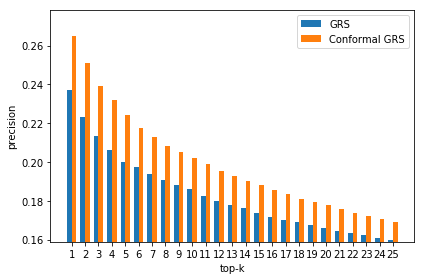

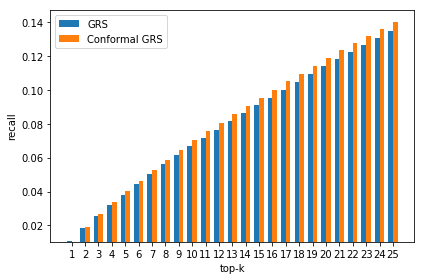

In [15]:
plot(g5,25,50)